In [1]:
# Load some libraries
import sys
import os
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
from lenspack.geometry.projections.gnom import radec2xy

from sp_validation import basic
from sp_validation import plots
from sp_validation import cosmology

%matplotlib inline

Could not import clmm.modeling, continuing...


In [2]:
# Load parameter file, containing useful variables (e.g. file paths)
%run params.py

Field name = W3


In [3]:
# Load catalogue with all objects (detected on stacks/tiles)
dd = np.load(galaxy_cat_path, mmap_mode=mmap_mode)

In [4]:
# Print the column names
print(dd.dtype.names)

('XWIN_WORLD', 'YWIN_WORLD', 'TILE_ID', 'FLAGS', 'IMAFLAGS_ISO', 'NGMIX_MCAL_FLAGS', 'NGMIX_ELL_PSFo_NOSHEAR', 'GALSIM_PSF_ELL_ORIGINAL_PSF', 'SPREAD_CLASS', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'N_EPOCH', 'NGMIX_N_EPOCH', 'NGMIX_ELL_1M', 'NGMIX_ELL_1P', 'NGMIX_ELL_2M', 'NGMIX_ELL_2P', 'NGMIX_ELL_NOSHEAR', 'NGMIX_ELL_ERR_NOSHEAR', 'NGMIX_FLAGS_1M', 'NGMIX_FLAGS_1P', 'NGMIX_FLAGS_2M', 'NGMIX_FLAGS_2P', 'NGMIX_FLAGS_NOSHEAR', 'NGMIX_T_1M', 'NGMIX_T_1P', 'NGMIX_T_2M', 'NGMIX_T_2P', 'NGMIX_T_NOSHEAR', 'NGMIX_T_ERR_1M', 'NGMIX_T_ERR_1P', 'NGMIX_T_ERR_2M', 'NGMIX_T_ERR_2P', 'NGMIX_T_ERR_NOSHEAR', 'NGMIX_Tpsf_1M', 'NGMIX_Tpsf_1P', 'NGMIX_Tpsf_2M', 'NGMIX_Tpsf_2P', 'NGMIX_Tpsf_NOSHEAR', 'NGMIX_FLUX_1M', 'NGMIX_FLUX_1P', 'NGMIX_FLUX_2M', 'NGMIX_FLUX_2P', 'NGMIX_FLUX_NOSHEAR', 'NGMIX_FLUX_ERR_1M', 'NGMIX_FLUX_ERR_1P', 'NGMIX_FLUX_ERR_2M', 'NGMIX_FLUX_ERR_2P', 'NGMIX_FLUX_ERR_NOSHEAR', 'GALSIM_GAL_ELL_1M', 'GALSIM_GAL_ELL_1P', 'GALSIM_GAL_ELL_2M', 'GALSIM_GAL_ELL_2P', 'GALSIM_GAL_ELL_NOSHEAR', 'GAL

In [5]:
dd.shape

(5367032,)

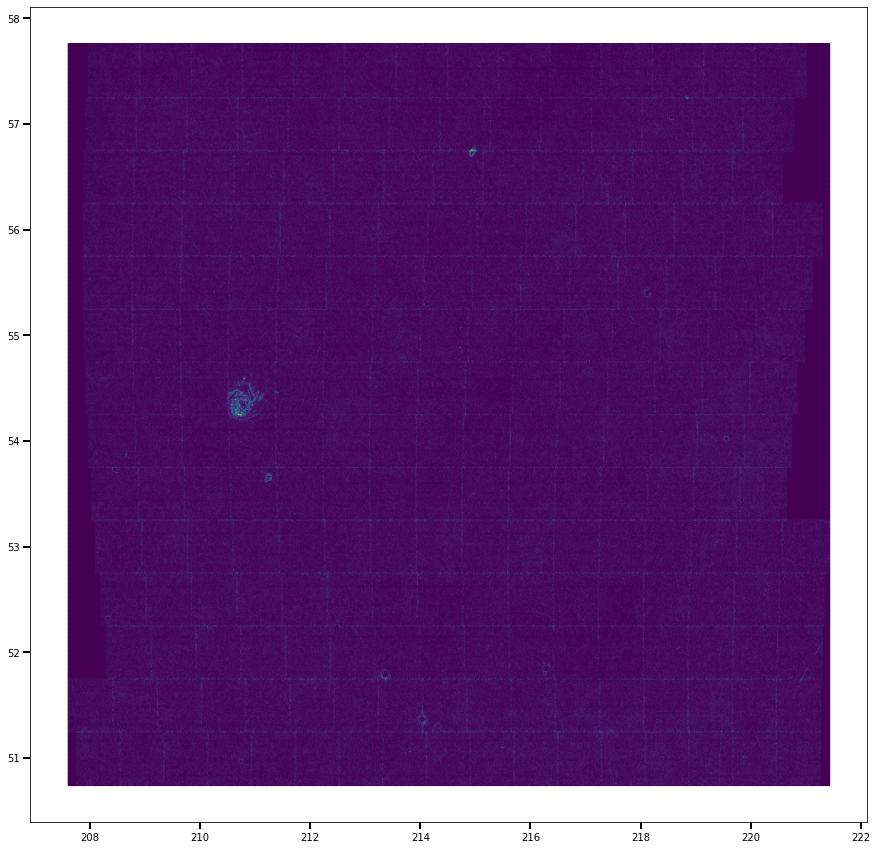

In [8]:
# Plot 2D distribution of all objects
# use XWIN_WORLD YWIN_WORLD
plt.figure(figsize=(15, 15))
plt.hexbin(dd['XWIN_WORLD'], dd['YWIN_WORLD'], gridsize=1000)

In [9]:
# Plot magnitude histogram
# MAG_AUTO

In [10]:
# Select galaxies
## Spread model, including error. Only use objects above some threshold
sm_classif = dd['SPREAD_MODEL'] + 2 * dd['SPREADERR_MODEL']

# Also cut on spread model directly, select magnitude range, remove flagged objects
cut_common = \
    (sm_classif > 0.0035) \
    & (dd['SPREAD_MODEL'] > 0) \
    & (dd['SPREAD_MODEL'] < 0.03) \
    & (dd['MAG_AUTO'] < 26) \
    & (dd['MAG_AUTO'] > 20) \
    & (dd['FLAGS'] == 0) \
    & (dd['IMAFLAGS_ISO'] == 0) \
    & (dd['N_EPOCH'] > 0)

# Add cut on relative size compared to PSF
cut_size = (
    dd['NGMIX_T_NOSHEAR'] / dd['NGMIX_Tpsf_NOSHEAR'] > 0.5
)

# Duplicate objects due to tile overlaps
cut_overlap = (
    dd['FLAG_TILING'] == 1
)

# Add ngmix-specific cuts. Create mask
m_gal_ngmix = (
    cut_common
    & cut_overlap
    & cut_size
    & (dd['NGMIX_MCAL_FLAGS'] == 0)
    & (dd['NGMIX_ELL_PSFo_NOSHEAR'][:,0] != -10)
    & (dd['NGMIX_MOM_FAIL'] == 0)
    & (dd['NGMIX_N_EPOCH'] > 0)
)

/var/folders/yw/kv0bbn697gj3g8mppm7n8lg00000gn/T/ipykernel_94143/243302455.py:18: RuntimeWarning: invalid value encountered in true_divide
  dd['NGMIX_T_NOSHEAR'] / dd['NGMIX_Tpsf_NOSHEAR'] > 0.5


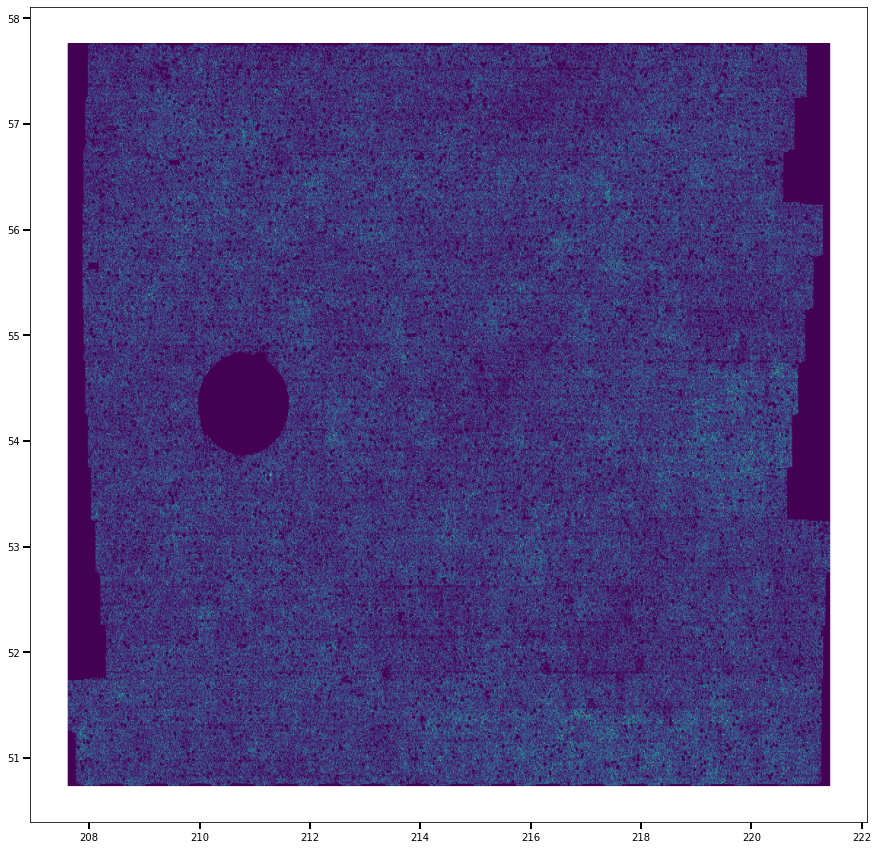

In [11]:
# Plot sky area of unflagged galaxies# Load some libraries
plt.figure(figsize=(15, 15))
plt.hexbin(dd['XWIN_WORLD'][m_gal_ngmix], dd['YWIN_WORLD'][m_gal_ngmix], gridsize=1000)

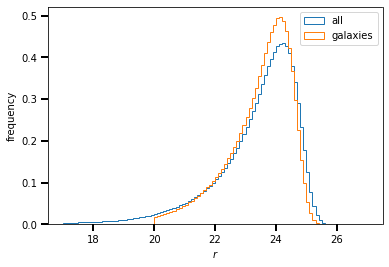

In [22]:
_ = plt.hist(dd['MAG_AUTO'], range=[17,27], bins=100, density=True,
             histtype='step', label='all')
_ = plt.hist(dd['MAG_AUTO'][m_gal_ngmix], range=[17,27], bins=100,
             density=True, histtype='step', label='galaxies')
plt.xlabel('$r$')
plt.ylabel('frequency')
plt.legend()

In [27]:
print(dd['NGMIX_ELL_1P'][m_gal_ngmix][:,0])
print(dd['NGMIX_ELL_1M'][m_gal_ngmix][:,0])

[ 0.0971 -0.558  0.00522 ... -0.408 -0.304 -0.351]
[ 0.0768 -0.571 -0.0113 ... -0.414 -0.314 -0.367]


In [29]:
R11 = (dd['NGMIX_ELL_1P'][m_gal_ngmix][:,0] - dd['NGMIX_ELL_1M'][m_gal_ngmix][:,0]) / 0.02
R22 = (dd['NGMIX_ELL_2P'][m_gal_ngmix][:,1] - dd['NGMIX_ELL_2M'][m_gal_ngmix][:,1]) / 0.02
R12 = (dd['NGMIX_ELL_1P'][m_gal_ngmix][:,1] - dd['NGMIX_ELL_1M'][m_gal_ngmix][:,1]) / 0.02
R21 = (dd['NGMIX_ELL_2P'][m_gal_ngmix][:,0] - dd['NGMIX_ELL_2M'][m_gal_ngmix][:,0]) / 0.02

In [36]:
# Create shear response matrix
m = np.mean
R = np.array([[m(R11), m(R12)], [m(R21), m(R22)]])
print(R)

[[ 0.631 -0.000307]
 [ 8.48e-05  0.624]]


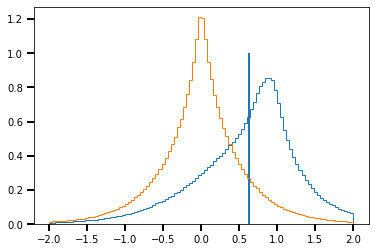

In [38]:
_ = plt.hist(R11, range=[-2, 2], bins=100, histtype='step', density=True)
_ = plt.hist(R12, range=[-2, 2], bins=100, histtype='step', density=True)
plt.vlines(x=np.mean(R11), ymin=0, ymax=1)

In [42]:
g_uncorr = dd['NGMIX_ELL_NOSHEAR'][m_gal_ngmix].transpose()

In [43]:
# Corrected (= calibrated by multiplicative bias) ellipticities
g_corr = np.linalg.inv(R).dot(g_uncorr)

In [44]:
g_uncorr

array([[ 0.087, -0.564, -0.0029, ..., -0.407, -0.306, -0.362],
       [-0.273, -0.13,  0.156, ...,  0.143, -0.15,  0.428]])

In [47]:
g_corr.shape

(2, 2665768)

In [49]:
c1 = np.mean(g_corr[0,:])
c2 = np.mean(g_corr[1,:])
print(c1, c2)

-0.00034746695749074766 0.0004928182503470647


In [51]:
# Store shear estimate calibrated of m and c
g_cal = np.zeros_like(g_corr)
g_cal[0] = g_corr[0,:] - c1
g_cal[1] = g_corr[1,:] - c2

In [55]:
w = np.where(dd['NGMIX_ELL_PSFo_NOSHEAR'][:,0] != -10)
print(
    np.mean(dd['NGMIX_ELL_NOSHEAR'][w][:,0]),
    np.mean(dd['NGMIX_ELL_NOSHEAR'][w][:,1])
)

-0.002537370335321525 0.0003610385661857


In [56]:
# Mass maps

ra_ngmix = dd['XWIN_WORLD'][m_gal_ngmix]
dec_ngmix = dd['YWIN_WORLD'][m_gal_ngmix]
ra_ngmix_mean = np.mean(ra_ngmix)
dec_ngmix_mean = np.mean(dec_ngmix)

# Projection all objects from spherical to Cartesian coordinates
x, y =  radec2xy(ra_ngmix_mean, dec_ngmix_mean, ra_ngmix, dec_ngmix)

min_x = np.min(x)
max_x = np.max(x)
min_y = np.min(y)
max_y = np.max(y)

size_x = max_x - min_x
size_y = max_y - min_y
size_x_deg = np.rad2deg(size_x)
size_y_deg = np.rad2deg(size_y)

print(f'Field size in projected coordinates is (x, y) = ({size_x_deg:.2f}, {size_y_deg:.2f}) deg')

Field size in projected coordinates is (x, y) = (8.59, 7.19) deg


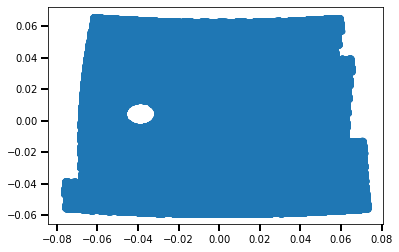

In [57]:
_ = plt.plot(x, y, '.')

In [58]:
pixel_size_emap_amin

0.4

In [59]:
# Compute number of pixels
Nx = int(size_x_deg / pixel_size_emap_amin * 60)
Ny = int(size_y_deg / pixel_size_emap_amin * 60)
print(f'Numbers of elipticity pixels for KS93 = ({Nx}, {Ny})')

Numbers of elipticity pixels for KS93 = (1288, 1079)


In [60]:
# Bin in 2D
g1_tmp, g2_tmp = bin2d(
    x,
    y,
    npix=(Nx, Ny), 
    v=(g_cal[0], g_cal[1]),
    extent=(min_x, max_x, min_y, max_y)
)

g_corr_mc_ngmix_map = np.array([g1_tmp, g2_tmp])

(array([   0,    0,    0, ..., 1078, 1078, 1078]),
 array([541, 549, 550, ..., 133, 134, 137]))

In [63]:
kappaE, kappaB = ks93(g_corr_mc_ngmix_map[0], -g_corr_mc_ngmix_map[1])

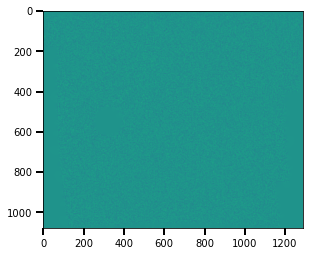

In [68]:
plt.imshow(kappaE)

In [69]:
smoothing_scale_pix

20

In [70]:
# Smooth with Gaussian filter
kappaE_sm = gaussian_filter(kappaE, smoothing_scale_pix)
kappaB_sm = gaussian_filter(kappaB, smoothing_scale_pix)

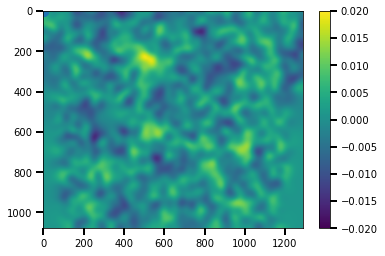

In [80]:
plt.imshow(kappaE_sm)
plt.colorbar()
plt.gci().set_clim([-0.02, 0.02])

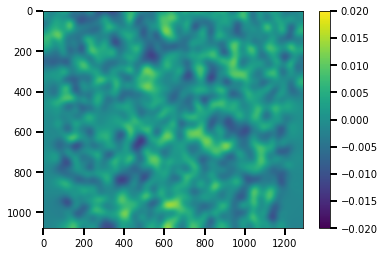

In [75]:
plt.imshow(kappaB_sm)
plt.colorbar()
plt.gci().set_clim([-0.02, 0.02])

In [76]:
# Get Planck clusters

cluster_cat_name = f'{data_dir}/HFI_PCCS_SZ-union_R2.08.fits.gz'
cluster_cat = fits.getdata(cluster_cat_name)

# Use clusters ok for cosmology
m_good_cluster = (cluster_cat['MSZ'] != 0) & (cluster_cat['COSMO'] == True)

# Get footprint masking function
get_mask = getattr(basic, 'get_mask_footprint_{}'.format(name))

# Find clusters in W3
m_cluster_foot = get_mask(cluster_cat['RA'][m_good_cluster], cluster_cat['DEC'][m_good_cluster])
clusters = {
    'ra': cluster_cat['RA'][m_good_cluster][m_cluster_foot],
    'dec': cluster_cat['DEC'][m_good_cluster][m_cluster_foot],
    'z': cluster_cat['REDSHIFT'][m_good_cluster][m_cluster_foot],
    'M': cluster_cat['MSZ'][m_good_cluster][m_cluster_foot] * 1e14,
}

In [78]:
# Project and add x, y, to clusters dictionary
x_cluster, y_cluster =  radec2xy(ra_ngmix_mean, dec_ngmix_mean, clusters['ra'], clusters['dec'])
clusters['x'] = x_cluster
clusters['y'] = y_cluster

In [79]:
clusters

{'ra': array([ 219,  217,  217,  214]),
 'dec': array([ 55.1,  55.7,  56.9,  54.8]),
 'z': array([ 0.14,  0.132,  0.105,  0.631], dtype=float32),
 'M': array([ 2.77e+14,  2.83e+14,  2.81e+14,  6.85e+14], dtype=float32),
 'x': array([ 0.0419,  0.0211,  0.024, -0.00964]),
 'y': array([ 0.0185,  0.0282,  0.048,  0.011])}

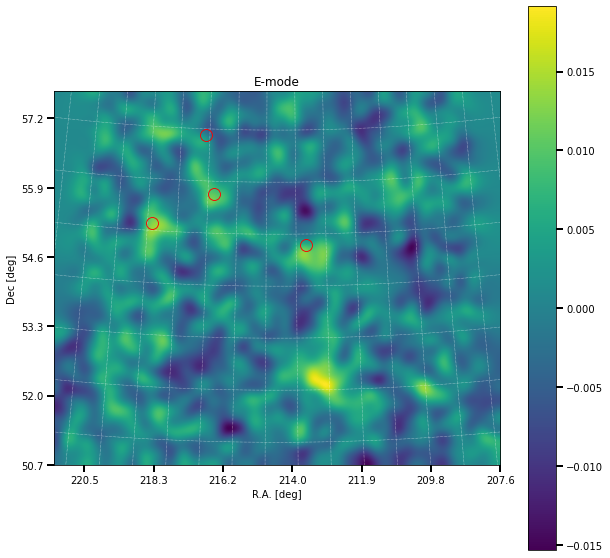

In [85]:
# Joint plot
title = 'E-mode'
out_path = 'kappaE.png'
vlim = plots.plot_map(kappaE_sm, ra_ngmix, dec_ngmix, min_x, max_x, min_y, max_y, Nx, Ny, title, out_path, clusters=clusters)

(-0.015334161036536259, 0.019123035249594418)

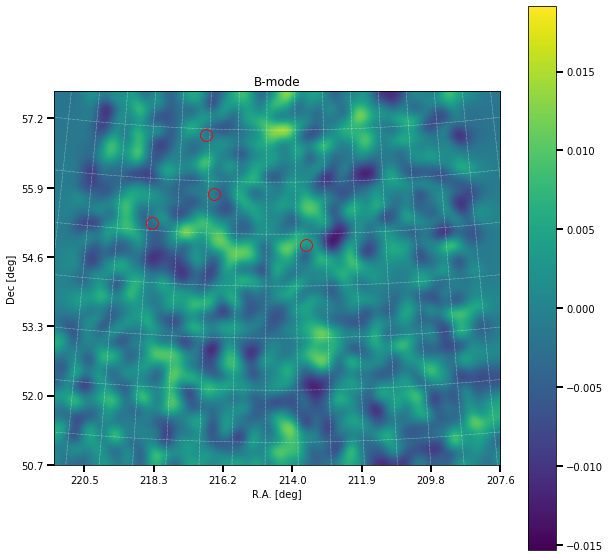

In [86]:
# Joint plot
title = 'B-mode'
out_path = 'kappaB.png'
plots.plot_map(kappaB_sm, ra_ngmix, dec_ngmix, min_x, max_x, min_y, max_y, Nx, Ny, title, out_path, clusters=clusters, vlim=vlim)

In [87]:
# Comoving separation around cluster centers, at cluster redshift, in [Mpc]
radius = 5

# Stack galaxies
res_stack_mm = cosmology.stack_mm3(
    ra_ngmix,
    dec_ngmix,
    g_cal[0],
    g_cal[1],
    np.ones_like(ra_ngmix),
    clusters['ra'],
    clusters['dec'],
    clusters['z'],
    radius=radius, n_match=1000000
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.20it/s]


Text(0.5, 1.0, 'Density plot')

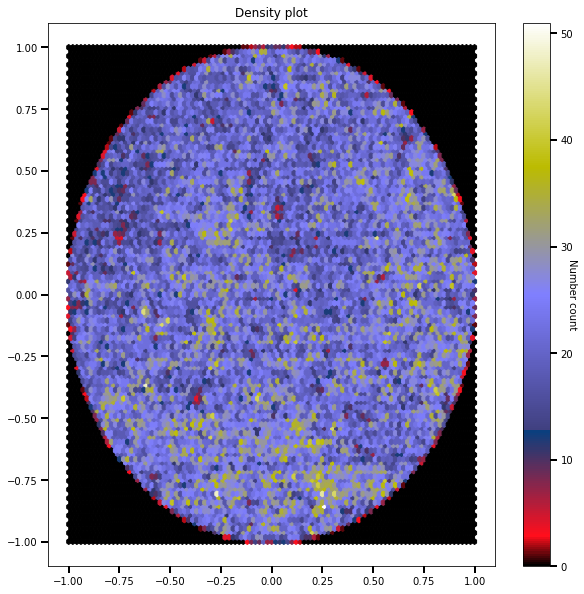

In [88]:
# Plot stacked galaxy density, to check how uniform distribution is. Sometimes at the edges the number
# of galaxies drops visibly

plt.figure(figsize=(10, 10))
plt.hexbin(res_stack_mm[0], res_stack_mm[1], gridsize=100, cmap='gist_stern')
cbar = plt.colorbar()
cbar.set_label('Number count', rotation=270)
plt.title('Density plot')

In [89]:
# Bin stacked ellipticities

npix = 2048
e1map_stack, e2map_stack = bin2d(
    res_stack_mm[0],
    res_stack_mm[1],
    v=(res_stack_mm[2], -res_stack_mm[3]),
    w=res_stack_mm[4], 
    npix=npix
)

In [90]:
# transform to gamma -> kappa via the aisers & Squires (1993) algorithm
kappaE_stack, kappaB_stack = ks93(e1map_stack, e2map_stack)

# Smooth
kappaE_stack_sm = gaussian_filter(kappaE_stack, smoothing_scale_pix)
kappaB_stack_sm = gaussian_filter(kappaB_stack, smoothing_scale_pix)

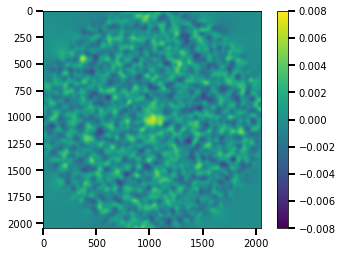

In [95]:
plt.imshow(kappaE_stack_sm)
plt.colorbar()
plt.gci().set_clim([-0.008, 0.008])

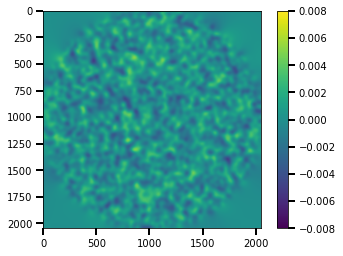

In [96]:
plt.imshow(kappaB_stack_sm)
plt.colorbar()
plt.gci().set_clim([-0.008, 0.008])

In [102]:
# PSF leakage

x = dd['NGMIX_ELL_PSFo_NOSHEAR'][:,0][m_gal_ngmix]
#y = g_cal[0]
y = g_corr[0]

def lin(x, a, b):
    return a * x + b

# Bin x and y
n_bin = 30
x_bin = []
y_bin = []

# objects per bin
size_bin = int(len(y) / n_bin)
diff_size = len(y) - size_bin

# Sort x
x_arg_sort = np.argsort(x)

for i in range(n_bin):
    if i < diff_size:
        bin_size_tmp = size_bin + 1
        starter = 0
    else:
        bin_size_tmp = size_bin
        starter = diff_size
    ind = x_arg_sort[starter + i * bin_size_tmp : starter + (i + 1) * bin_size_tmp]
    x_bin.append(np.mean(x[ind]))
    y_bin.append(np.mean(y[ind]))
   
x_bin = np.array(x_bin)
y_bin = np.array(y_bin)

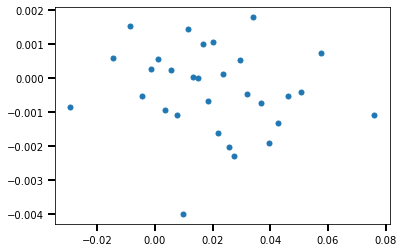

In [103]:
plt.plot(x_bin, y_bin, '.')

In [104]:
res = curve_fit(lin, x, y)

In [105]:
res

(array([-0.00911, -0.000163]),
 array([[ 0.00012, -2.42e-06],
        [-2.42e-06,  1.09e-07]]))

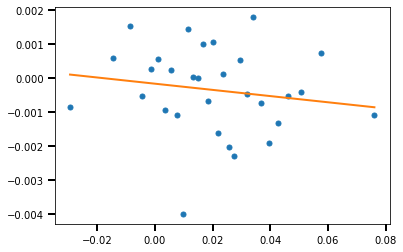

In [106]:
plt.plot(x_bin, y_bin, '.')
plt.plot(x_bin, lin(x_bin, *res[0]))